<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Autorec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q d2l torchinfo


     |████████████████████████████████| 82 kB 705 kB/s 
     |████████████████████████████████| 61 kB 8.4 MB/s 
     |████████████████████████████████| 15.7 MB 56.7 MB/s 
     |████████████████████████████████| 9.9 MB 53.3 MB/s 
     |████████████████████████████████| 11.2 MB 44.9 MB/s 
     |████████████████████████████████| 930 kB 43.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [178]:
import os
import pandas as pd
import numpy as np
import torch
import multiprocessing
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm
import math


In [179]:
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [180]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

number of users: 943, number of items: 1682
matrix sparsity: 0.936953


In [181]:
data.head(5)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [182]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [183]:
data.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


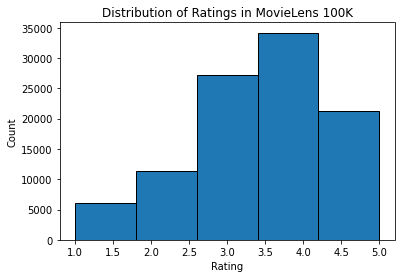

In [184]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

#Splitting the data

We split the dataset into training and test sets. The following function provides two split modes including random and seq-aware. In the random mode, the function splits the 100k interactions randomly without considering timestamp and uses the 90% of the data as training samples and the rest 10% as test samples by default. In the seq-aware mode, we leave out the item that a user rated most recently for test, and users’ historical interactions as training set. User historical interactions are sorted from oldest to newest based on timestamp. This mode will be used in the sequence-aware recommendation section.

In [185]:
#We have atleast 96 entries per user
#If we had 1 entry only, we can't use it in the test set and hence can omit that user
min(data.groupby('user_id')['user_id'].sum())

96

In [186]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    columns= list(data.columns)
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in tqdm(data.to_dict('records')):
            u, i, rating, time = line['user_id'], line['item_id'], line['rating'], line['timestamp']
            #key-> user_id value-> all instances of u
            train_items.setdefault(u, []).append((u, i, rating, time))
            #for every unique u make an entry and if u already exists
            # replace the entry by most recent entry for u
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            #list of tuples
            train_list.extend(sorted(train_items[u], key=lambda k: k[-1]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data,columns=columns)
        test_data = pd.DataFrame(test_data,columns=columns)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

#Load Data
After dataset splitting, we will convert the training set and test set into lists and dictionaries/matrix for the sake of convenience. The following function reads the dataframe line by line and enumerates the index of users/items start from zero. The function then returns lists of users, items, ratings and a dictionary/matrix that records the interactions. We can specify the type of feedback to either explicit or implicit

In [187]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in tqdm(data.to_dict('records')):
        #subtract 1 since user_id & item_id start from 1
        user_index, item_index = int(line['user_id'] - 1), int(line['item_id'] - 1)
        score = int(line['rating']) if feedback == 'explicit' else 1
        users.append(user_index) #len num interactions
        items.append(item_index) #len num interactions
        scores.append(score)     #len num interactions
        if feedback == 'implicit':
            #for each user, list of items interacted with
            inter.setdefault(user_index, []).append(item_index)
        else:
            #num_items x num_users matrix with interaction scores at each position
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [188]:
def create_iterator(dataset,batch_size,is_train=True):
  return torch.utils.data.DataLoader(dataset,batch_size,shuffle=is_train,num_workers=multiprocessing.cpu_count())

In [189]:
print(*torch.tensor(np.array([[1,2],[2,1]])))

tensor([1, 2]) tensor([2, 1])


In [190]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(data, num_users, num_items, split_mode, test_ratio)
    _, _, _, train_inter_mat = load_data_ml100k(train_data, num_users, num_items, feedback)
    _, _, _, test_inter_mat = load_data_ml100k(test_data, num_users, num_items, feedback)
    
    train_inter_mat = torch.tensor(train_inter_mat,dtype=torch.float32)
    test_inter_mat = torch.tensor(test_inter_mat,dtype=torch.float32)

    train_iter= create_iterator ((train_inter_mat),batch_size=batch_size,is_train=True)
    
    test_iter= create_iterator ((test_inter_mat),batch_size=batch_size*4,is_train=False)
    return num_users,num_items,train_iter, test_iter

In [191]:
num_users, num_items, train_iter, test_iter= split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',test_ratio=0.1, batch_size=256)

100%|██████████| 943/943 [00:00<00:00, 645435.49it/s]


In [192]:
print(num_users, num_items)

943 1682


In [193]:
for batch in train_iter:
  print(len(batch))
  print(batch[0].shape)
  break

256
torch.Size([943])


In [194]:
for batch in test_iter:
  print(len(batch))
  print(batch[0].shape)
  break

1024
torch.Size([943])


In [195]:
len(train_iter),len(test_iter)

(7, 2)

#Building the Model


On one hand, AutoRec has the same structure as an autoencoder which consists of an input layer, a hidden layer, and a reconstruction (output) layer.  An autoencoder is a neural network that learns to copy its input to its output in order to code the inputs into the hidden (and usually low-dimensional) representations. **In AutoRec, instead of explicitly embedding users/items into low-dimensional space, it uses the column/row of the interaction matrix as the input, then reconstructs the interaction matrix in the output layer.**

On the other hand, AutoRec differs from a traditional autoencoder: rather than learning the hidden representations, AutoRec focuses on learning/reconstructing the output layer. It uses a partially observed interaction matrix as the input, aiming to reconstruct a completed rating matrix. In the meantime, the missing entries of the input are filled in the output layer via reconstruction for the purpose of recommendation. 

**There are two variants of AutoRec: user-based and item-based. For brevity, here we only introduce the item-based AutoRec. User-based AutoRec can be derived accordingly.**

**This means that in a batch for every item in that batch we have an input of len num_users which shows what that item is rated by every user. Of course the items not rated by the user are represented by zero and masked out as we will see.**


Let $\mathbf{R}_{*i}$ denote the $i^\mathrm{th}$ column of the rating matrix, where unknown ratings are set to zeros by default. The neural architecture is defined as:

$$
h(\mathbf{R}_{*i}) = f(\mathbf{W} \cdot g(\mathbf{V} \mathbf{R}_{*i} + \mu) + b)
$$

where $f(\cdot)$ and $g(\cdot)$ represent activation functions, $\mathbf{W}$ and $\mathbf{V}$ are weight matrices, $\mu$ and $b$ are biases. Let $h( \cdot )$ denote the whole network of AutoRec. The output $h(\mathbf{R}_{*i})$ is the reconstruction of the $i^\mathrm{th}$ column of the rating matrix.

The following objective function aims to minimize the reconstruction error:

$$
\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{R}_{*i} - h(\mathbf{R}_{*i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)
$$

where $\| \cdot \|_{\mathcal{O}}$ means only the contribution of observed ratings are considered, that is, only weights that are associated with observed inputs are updated during back-propagation.


In [196]:
class AutoRec(nn.Module):
  def __init__(self,num_hiddens,num_users,dropout=0.05):
    super(AutoRec, self).__init__()
    self.encoder = nn.Linear(num_users,num_hiddens,bias=True)
    self.sigmoid = nn.Sigmoid()
    self.decoder = nn.Linear(num_hiddens,num_users, bias=True)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self,inputs):
    #inputs -> batch_size X num_users
    hidden = self.dropout(self.sigmoid(self.encoder(inputs)))
    preds= self.decoder(hidden)
    #if self.training:  # Mask the gradient during training
    return preds
    #else: 
      #return preds


In [197]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight,0.01)


In [198]:
def evaluate_rmse_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval() # Set the model to evaluation mode 
    if not device:
      device = next(iter(net.parameters())).device 

  # No. of correct predictions, no. of predictions 
  scores=[]
  with torch.no_grad():
    for batch in data_iter:
      batch = batch.to(device)
      preds = net(batch) * (batch > 0).to(torch.float32)
      se = nn.MSELoss(reduction='mean')(preds,batch)
      scores.append(se)

  return torch.sqrt(sum(scores)/len(scores)).item()

In [199]:
def train_batch(net,X,y,loss,optimizer,devices=d2l.try_all_gpus()):
  X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  optimizer.zero_grad()
  pred = net(X) * (y > 0).to(torch.float32)
  l = loss(pred,y)
  l.backward()
  optimizer.step()
  
  return l

In [200]:
nn.MSELoss(reduction='none')(torch.tensor([[1,2],[0,0]],dtype=torch.float32),torch.tensor([[1,1],[0,5]],dtype=torch.float32))

tensor([[ 0.,  1.],
        [ 0., 25.]])

In [201]:
nn.MSELoss(reduction='sum')(torch.tensor([[1,2],[-0,0]],dtype=torch.float32),torch.tensor([[1,2],[0,5]],dtype=torch.float32))

tensor(25.)

In [202]:
nn.MSELoss(reduction='mean')(torch.tensor([[1,2],[-0,0]],dtype=torch.float32),torch.tensor([[1,2],[0,5]],dtype=torch.float32))

tensor(6.2500)

In [203]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  scores = []
  for epoch in range(num_epochs):
    for batch in train_iter:
      timer.start()
      l=train_batch(net,batch,batch,loss,trainer,devices)
      scores.append(l)
      timer.stop()
    train_mse = (sum(scores)/len(scores)).item()
    test_rmse = evaluate_rmse_gpu(net, test_iter)
    print(f'epoch {epoch+1}: train MSE {train_mse:.3f} test RMSE {test_rmse:.3f}') 


In [204]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(test_ratio=0.1, batch_size=256)
net = AutoRec(500, num_users)
net.apply(init_weights)

100%|██████████| 943/943 [00:00<00:00, 354062.19it/s]


AutoRec(
  (encoder): Linear(in_features=943, out_features=500, bias=True)
  (sigmoid): Sigmoid()
  (decoder): Linear(in_features=500, out_features=943, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

In [205]:
from torchinfo import summary
summary(net)


Layer (type:depth-idx)                   Param #
AutoRec                                  --
├─Linear: 1-1                            472,000
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            472,443
├─Dropout: 1-4                           --
Total params: 944,443
Trainable params: 944,443
Non-trainable params: 0

In [206]:
lr, num_epochs, wd= 0.1, 50, 1e-5
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

loss = nn.MSELoss(reduction='mean')

train(net, train_iter, test_iter, loss, optimizer, num_epochs,devices)

epoch 1: train MSE 9.164 test RMSE 0.384
epoch 2: train MSE 5.470 test RMSE 0.327
epoch 3: train MSE 3.932 test RMSE 0.284
epoch 4: train MSE 3.079 test RMSE 0.260
epoch 5: train MSE 2.537 test RMSE 0.232
epoch 6: train MSE 2.160 test RMSE 0.212
epoch 7: train MSE 1.884 test RMSE 0.199
epoch 8: train MSE 1.673 test RMSE 0.186
epoch 9: train MSE 1.507 test RMSE 0.175
epoch 10: train MSE 1.372 test RMSE 0.164
epoch 11: train MSE 1.261 test RMSE 0.156
epoch 12: train MSE 1.168 test RMSE 0.147
epoch 13: train MSE 1.089 test RMSE 0.140
epoch 14: train MSE 1.020 test RMSE 0.133
epoch 15: train MSE 0.960 test RMSE 0.128
epoch 16: train MSE 0.907 test RMSE 0.122
epoch 17: train MSE 0.860 test RMSE 0.116
epoch 18: train MSE 0.819 test RMSE 0.111
epoch 19: train MSE 0.781 test RMSE 0.107
epoch 20: train MSE 0.747 test RMSE 0.103
epoch 21: train MSE 0.716 test RMSE 0.100
epoch 22: train MSE 0.688 test RMSE 0.096
epoch 23: train MSE 0.662 test RMSE 0.093
epoch 24: train MSE 0.638 test RMSE 0.090
e